# Function to generate graphs

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def map_to_graph(group_dataframe, marginal_connections=True, node_color='purple', graph_title=''):
    """
    After generating a dataFrame containing the significant dDTFs with its corresponding labels, generate the 
    weighted graph.
    Input:
    group_dataframe: Panda dataframe where its values are the dDTF after the statistical test, index and columns are the
    IC labels in order (consult the components_labeled file from groupICA)
    marginal_connections: Flag to include marginal connections
    node_color: Color of the nodes (default is purple)
    graph_title: Title of the graph (default is an empty string)

    Output:
    Weighted-and-directed graph for the 10 main networks in a given group 
    """

    # Labels of the group's network
    group_labels = group_dataframe.index
    # Mapping of the sub-networks to the 10 main networks
    network_mapping = {'DDMN': 'DMN', 'VDMN': 'DMN', 'REC': 'EC', 'AS': 'SN', 'PS': 'SN', 'LEC': 'EC', 'SM': 'SM', 'HV': 'VN', 'PV': 'VN', 'LN': 'LN'}
    
    # We map the labels in the input dF to the main networks for both rows and columns
    mapped_labels = np.array([network_mapping[label] if label in network_mapping else label for label in group_labels])
    mapped_df = pd.DataFrame(group_dataframe.values, index=mapped_labels, columns=mapped_labels)
    
    # Now, we perform a "scaling" trough the mapped main network labels for both rows and columns and sum the values within each group
    scaled_df = mapped_df.groupby(level=0, axis=0).sum().groupby(level=0, axis=1).sum()
    
    # Since our graph doesn't consider self-interactions, we generate a copy its diagonal elements are 0
    # These values are still interesting, particularly for the DMN (it interacts a lot with itself)
    df = scaled_df.copy(deep=True) # This flag means that changes in the copied dataframe don't affect the original
    np.fill_diagonal(df.values, 0) # Setting all diagonal values to 0

    # We divide the values in four levels relative to the maximum value in the matrix (25,50,75,100%). 
    # I added an special case for "marginal connections" in range [1, 0.25*max_value]
    max_val = np.max(df.values)
    levels = [max_val * i for i in [0.25, 0.5, 0.75, 1.0]]
    # Mapping 
    weights_nc = np.digitize(df.values, bins=levels, right=False) / 4.0

    if marginal_connections:
        weights_condition = (df.values >= 1) & (df.values < levels[0])
        weights = np.where(weights_condition, 0.1, weights_nc)
    else:
        weights = weights_nc

    weights_df = pd.DataFrame(weights, columns=df.columns, index=df.index)

    # We can now print the graph
    G = nx.DiGraph()
    num_nodes = weights.shape[0]
    G.add_nodes_from(range(num_nodes))

    # Add directed edges with weights and distinguish dashed edges
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = weights[i, j]
            if weight > 0:
                edge_style = 'dashed' if weight == 0.1 else 'solid'
                G.add_edge(i, j, weight=weight, style=edge_style)
    
    # Extract edge weights and styles
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
    edge_styles = [data['style'] for _, _, data in G.edges(data=True)]

    node_labels = {i: scaled_df.index[i] for i in range(num_nodes)}

    # Graph with circular shape
    pos = nx.circular_layout(G)

    plt.figure(dpi=150)
    
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=700, font_size=8, font_color='white',
            font_weight='bold', node_color=node_color, edge_color='black', width=[2 * w for w in edge_weights],#double width!,
            style=edge_styles, connectionstyle='arc3,rad=0.05')


    plt.title(graph_title)

    plt.show()

    return(scaled_df, weights_df)


# Control

Component 07 ad1 is eye movement only, 21 is mainly eye movement, 31 too

In [3]:
import nibabel as nib
from mGrangerStats import *


control_ics = nib.load("E:/Internship/Group-IC/CN/cn_mean_timecourses_ica_s_all_.nii").get_fdata()

surrogate_control = mGrangerStats(control_ics)

surrogate_control_array = surrogate_control.generate_surrogate(num_sets=2500)

control_result = surrogate_control.significance_testing(surrogate_control_array, 0.05)

### Suppressed connections

In [4]:
print(np.size(control_result) - np.count_nonzero(control_result))

72


## Without marginal connections
### Graph

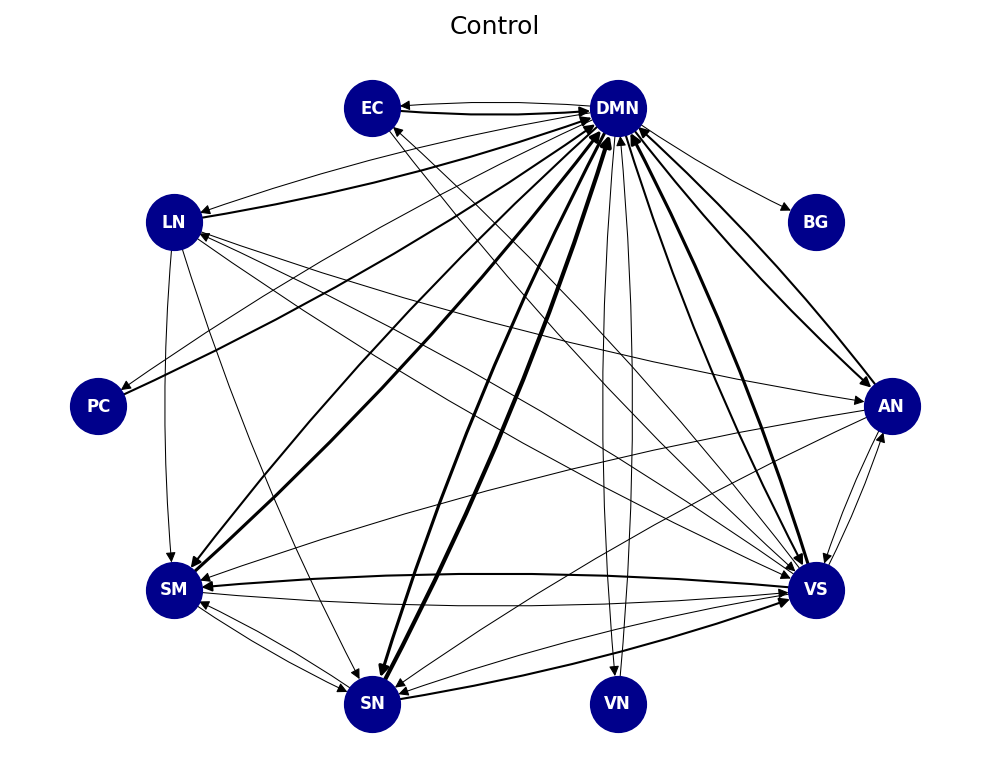

In [5]:
control_labels = np.array(['VS', 'AS', 'BG', 'DDMN', 'VS', 'AN', 'DDMN', 'REC', 'PC', 'VDMN', 'LN',
     'SM', 'PC', 'VDMN', 'LN', 'HV', 'VS', 'AN', 'VDMN', 'VDMN', 'REC', 'SM', 'LN', 'LEC', 'VS', 'PS', 
     'AN', 'SM', 'AS', 'HV', 'VDMN'])

df_control = pd.DataFrame(control_result, index=control_labels, columns=control_labels)

matrix_control, weights_control = map_to_graph(df_control, marginal_connections=False, node_color='darkblue', graph_title='Control')

### dDTF values matrix

It doesn't depend on the marginal connections, since they are computed after the scaled dDTF matrix wrt the 10 main networks

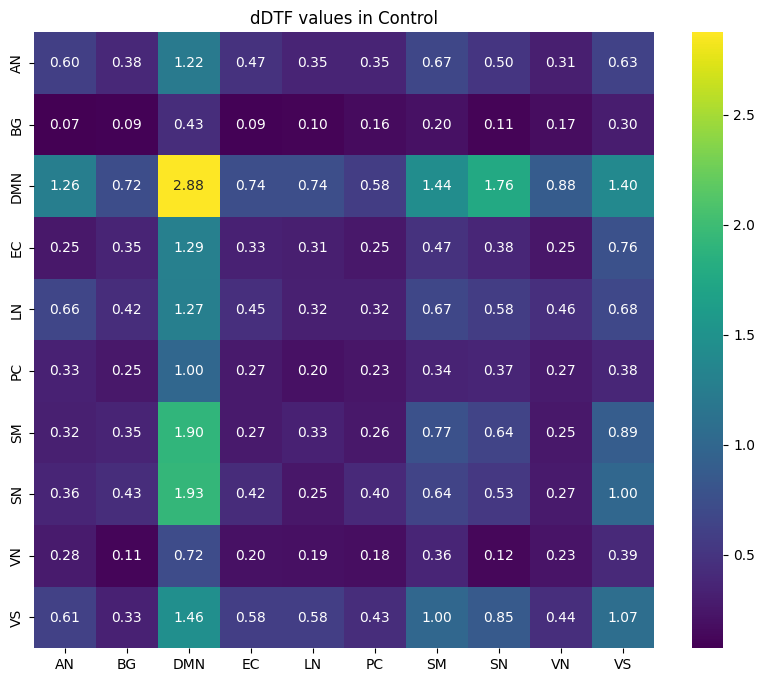

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix_control, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("dDTF values in Control")
plt.show()


### Standardized dDTF matrix in Control

All dDTF values from the previous matrix are scaled (standardized) to Z-scores using the formula:

$$
X_{\text{standardized}} = \frac{X-mean(X)}{std(X)}
$$

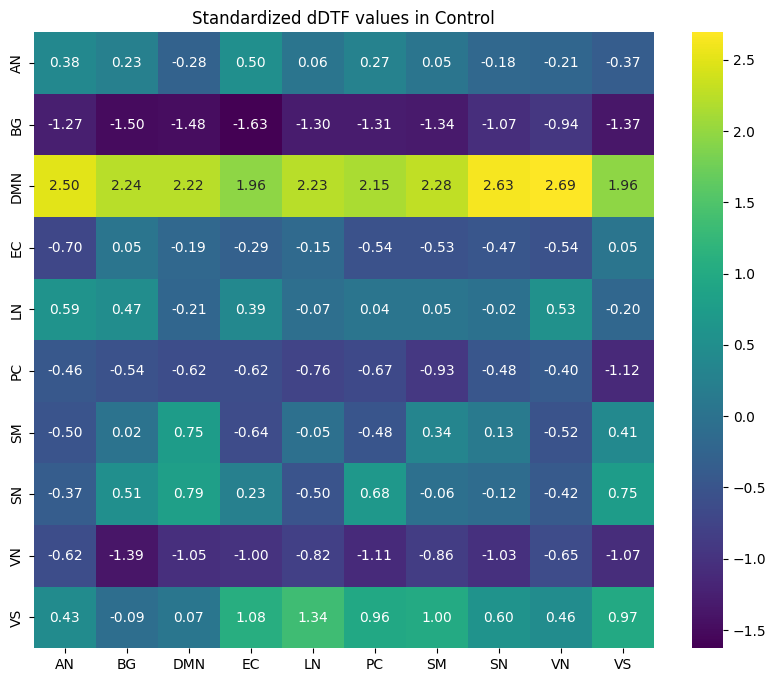

In [53]:
def normalize_matrix(matrix): #It's actually Z-scores!
    mean_values = np.mean(matrix, axis=0)
    std_values = np.std(matrix, axis=0)
    standardized_matrix = (matrix - mean_values) / std_values

    return standardized_matrix

plt.figure(figsize=(10, 8)) 
sns.heatmap(normalize_matrix(matrix_control), cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("Standardized dDTF values in Control")
plt.show()

### In/Out/In+Out degrees in Control

"In the context of a connectivity matrix, such as the dDTF matrix, the sum along an axis is a way to aggregate the connectivity strengths associated with each node. When you sum along a specific axis:

* Summing along axis 1 (columns) gives you the total connectivity strengths for each source node (out-degree).
* Summing along axis 0 (rows) gives you the total connectivity strengths for each target node (in-degree).

So, when you sum along axis 1, you get the out-degrees (connectivity strengths of each node as a source), and when you sum along axis 0, you get the in-degrees (connectivity strengths of each node as a target)."

In [8]:
control_in = np.sum(weights_control.values, axis=1)
control_out = np.sum(weights_control.values, axis=0)
control_in_out = control_in + control_out

# fd: flow-degrees, for in, out, in+out degrees
fd_control = pd.DataFrame(np.vstack((control_in, control_out, control_in_out)), columns=weights_control.columns, index=['In-Degree', 'Out-Degree', 'In+Out'])
fd_control

,AN,BG,DMN,EC,LN,PC,SM,SN,VN,VS
In-Degree,1.25,0.00,3.50,0.75,1.5,0.50,1.25,1.75,0.25,2.25
Out-Degree,1.00,0.25,4.75,0.50,0.5,0.25,1.75,1.75,0.25,2.00
In+Out,2.25,0.25,8.25,1.25,2.0,0.75,3.00,3.50,0.50,4.25


### Hubs in Control

"A node with ‘In + Out degree’ at least one standard deviation greater than the average ‘In + Out degree’ for all RSNs was identified as a hub in the network."

So, we compute the mean and standard deviation of the In+Out degrees for each group and print the names of the corresponding networks.

In [9]:
mean_io_cn = np.mean(fd_control.values[2,:]) #cn: control, io: in+out
sd_io_cn = np.std(fd_control.values[2,:])

for n in range(len(fd_control.values[2,:])):
    if fd_control.values[2,n] >= mean_io_cn + sd_io_cn:
        print(fd_control.columns[n])

DMN


### Mean and SD for In+Out values in control

In [10]:
print(mean_io_cn)
print(sd_io_cn)

2.6
2.2643983748448506


### Larger In-Degrees

In [11]:
mean_in_cn = np.mean(fd_control.values[0,:]) #cn: control, io: in+out
sd_in_cn = np.std(fd_control.values[0,:])

for n in range(len(fd_control.values[0,:])):
    if fd_control.values[0,n] >= mean_in_cn + sd_in_cn:
        print(fd_control.columns[n])

DMN


### Larger Out-Degrees

In [12]:
mean_out_cn = np.mean(fd_control.values[1,:]) #cn: control, io: in+out
sd_out_cn = np.std(fd_control.values[1,:])

for n in range(len(fd_control.values[1,:])):
    if fd_control.values[1,n] >= mean_out_cn + sd_out_cn:
        print(fd_control.columns[n])

DMN


# AD with Apathy with Depression - AD1

Precuneus network was not appropriately labeled, found by visual inspection in IC 16
Idem with Left executive control, found in IC 23.

In [13]:
import nibabel as nib
from mGrangerStats import *

ad1_ics = nib.load("E:/Internship/Group-IC/AD1/ad1_mean_timecourses_ica_s_all_.nii").get_fdata()

surrogate_ad1 = mGrangerStats(ad1_ics)

surrogate_array_ad1 = surrogate_ad1.generate_surrogate(num_sets=2500)

ad1_result = surrogate_ad1.significance_testing(surrogate_array_ad1, 0.05)

### Suppressed connections

In [14]:
print(np.size(ad1_result) - np.count_nonzero(ad1_result))

3


## Without marginal connections
### Graph

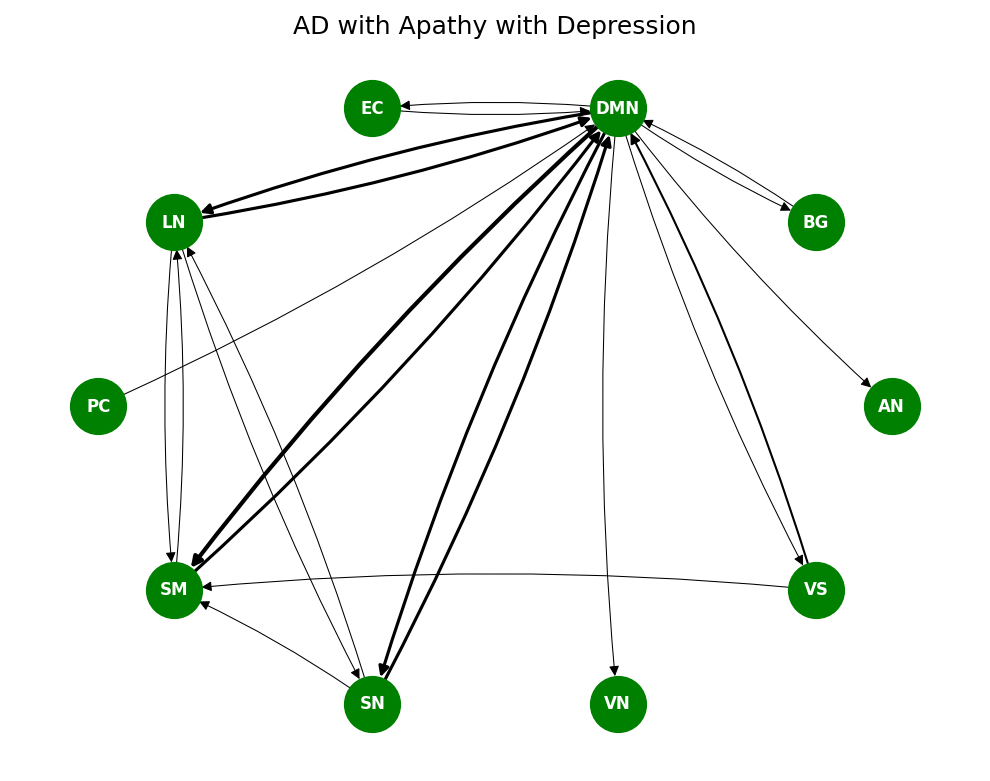

In [54]:
ad1_labels = np.array(['PS', 'DDMN', 'LN', 'HV', 'AS', 'VDMN', 'BG',
 'BG', 'SM', 'DDMN', 'SM', 'DDMN', 'DDMN', 'VDMN', 'VDMN', 'PC', 'SM', 'VDMN', 'PS',
 'DDMN', 'DDMN', 'AS', 'LEC', 'AN', 'SM', 'VS', 'LN', 'LN', 'REC', 'LN', 'VS'])

df_ad1 = pd.DataFrame(ad1_result, index=ad1_labels, columns=ad1_labels)

matrix_ad1, weights_ad1 = map_to_graph(df_ad1, marginal_connections=False, node_color='green', graph_title='AD with Apathy with Depression')

### dDTF values matrix

Independent of dDTF scale wrt maximum value.

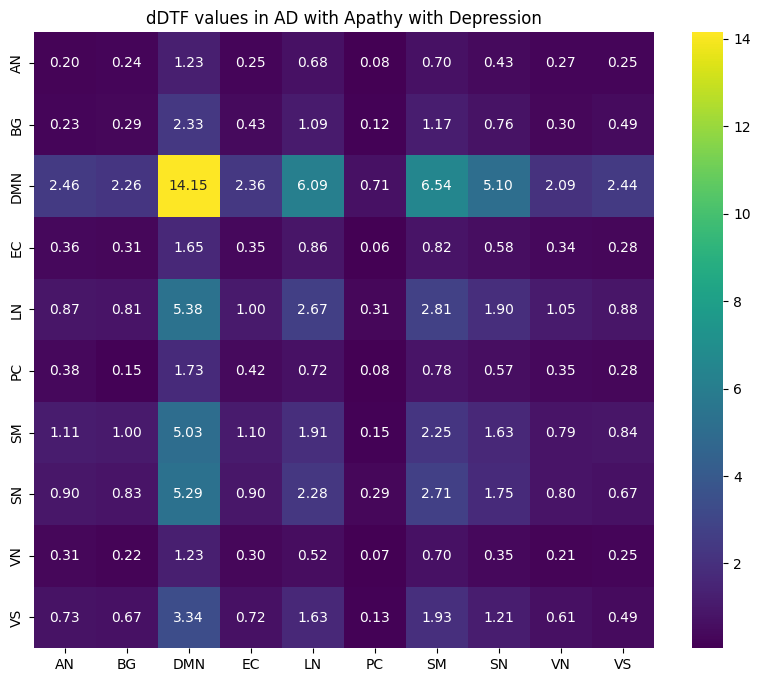

In [16]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix_ad1, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("dDTF values in AD with Apathy with Depression")
plt.show()

### Standardized dDTF matrix for AD1

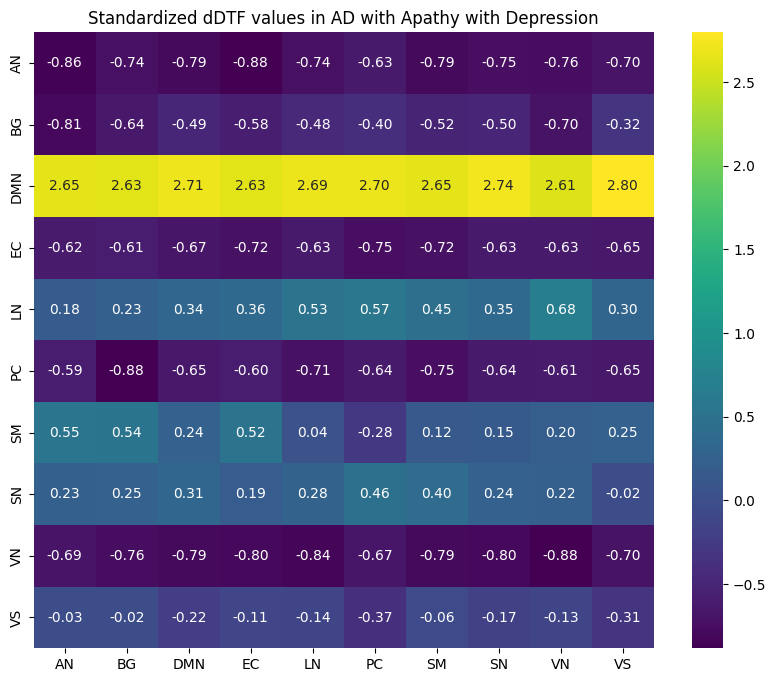

In [17]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(normalize_matrix(matrix_ad1), cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("Standardized dDTF values in AD with Apathy with Depression")
plt.show()

### In/Out/In+Out degrees in AD1

In [18]:
ad1_in = np.sum(weights_ad1.values, axis=1)
ad1_out = np.sum(weights_ad1.values, axis=0)
ad1_in_out = ad1_in + ad1_out

# fd: flow-degrees, for in, out, in+out degrees
fd_ad1 = pd.DataFrame(np.vstack((ad1_in, ad1_out, ad1_in_out)), columns=weights_ad1.columns, index=['In-Degree', 'Out-Degree', 'In+Out'])
fd_ad1

,AN,BG,DMN,EC,LN,PC,SM,SN,VN,VS
In-Degree,0.00,0.25,3.75,0.25,1.25,0.25,1.00,1.25,0.00,0.75
Out-Degree,0.25,0.25,3.50,0.25,1.25,0.00,1.75,1.00,0.25,0.25
In+Out,0.25,0.50,7.25,0.50,2.50,0.25,2.75,2.25,0.25,1.00


### Hubs in AD1

In [19]:
mean_io_ad1 = np.mean(fd_ad1.values[2,:]) #io: in+out
sd_io_ad1 = np.std(fd_ad1.values[2,:])

for n in range(len(fd_ad1.values[2,:])):
    if fd_ad1.values[2,n] >= mean_io_ad1 + sd_io_ad1:
        print(fd_ad1.columns[n])

DMN


### Mean and SD In+Out values in AD1

In [20]:
print(mean_io_ad1)
print(sd_io_ad1)

1.75
2.0615528128088303


### Larger In-degrees

In [21]:
mean_in_ad1 = np.mean(fd_ad1.values[0,:]) #cn: control, io: in+out
sd_in_ad1 = np.std(fd_ad1.values[0,:])

for n in range(len(fd_ad1.values[0,:])):
    if fd_ad1.values[0,n] >= mean_in_ad1 + sd_in_ad1:
        print(fd_ad1.columns[n])

DMN


### Larger Out-degrees

In [22]:
mean_out_ad1 = np.mean(fd_ad1.values[1,:]) #cn: control, io: in+out
sd_out_ad1 = np.std(fd_ad1.values[1,:])

for n in range(len(fd_ad1.values[1,:])):
    if fd_ad1.values[1,n] >= mean_out_ad1 + sd_out_ad1:
        print(fd_ad1.columns[n])

DMN


# AD with Apathy without Depression - AD2

Left executive control was visually found on IC 22.

In [23]:
ad2_ics = nib.load("E:/Internship/Group-IC/AD2/ad2_mean_timecourses_ica_s_all_.nii").get_fdata()

surrogate_ad2 = mGrangerStats(ad2_ics)

surrogate_array_ad2 = surrogate_ad2.generate_surrogate(num_sets=2500)

ad2_result = surrogate_ad2.significance_testing(surrogate_array_ad2, 0.05)

### Suppressed connections

In [24]:
print(np.size(ad2_result) - np.count_nonzero(ad2_result))

1


## Without marginal connections

### Graph

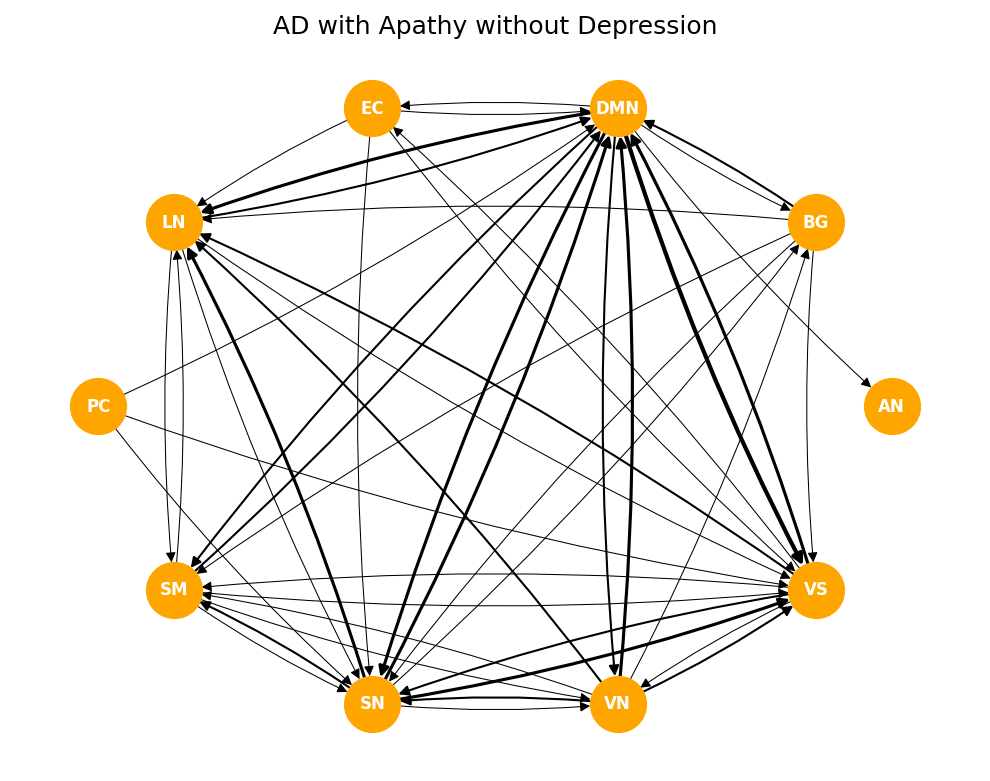

In [25]:
ad2_labels = np.array(['VS', 'AS', 'HV', 'DDMN', 'LN', 'LN', 'DDMN', 'VS', 'VS', 
    'BG', 'SM', 'AS', 'PV', 'PS', 'PC', 'VS', 'AS', 'BG', 'DDMN', 'REC', 'VS', 'LEC', 
    'PS', 'VDMN', 'HV', 'AN', 'DDMN', 'LN', 'SM', 'DDMN', 'SM'])

df_ad2 = pd.DataFrame(ad2_result, index=ad2_labels, columns=ad2_labels)

matrix_ad2, weights_ad2 = map_to_graph(df_ad2, marginal_connections=False, node_color='orange', graph_title='AD with Apathy without Depression')

### dDTF values matrix

Independent of dDTF scaling wrt maximum value

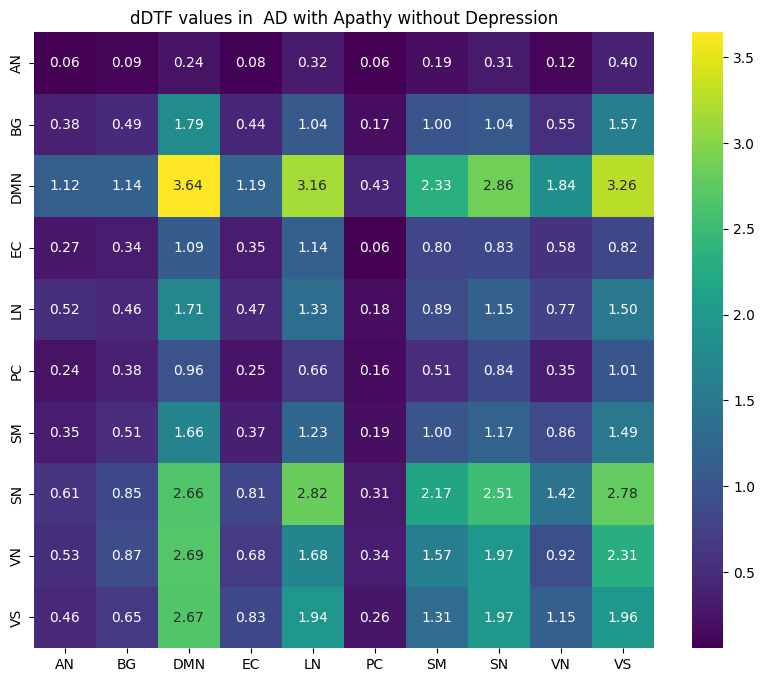

In [26]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix_ad2, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("dDTF values in  AD with Apathy without Depression")
plt.show()

### Scaled dDTF matrix in AD2

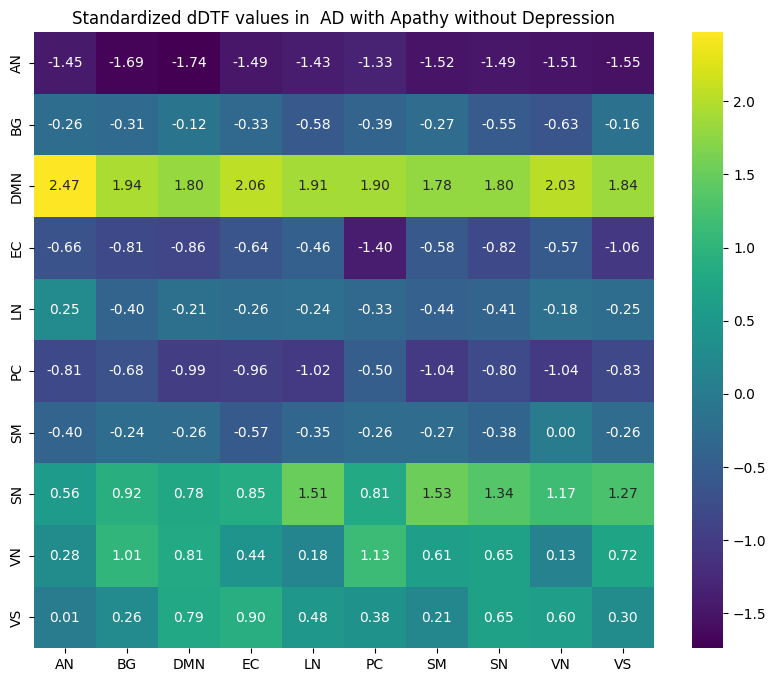

In [27]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(normalize_matrix(matrix_ad2), cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("Standardized dDTF values in  AD with Apathy without Depression")
plt.show()

### In+Out Degrees in AD2

In [28]:
ad2_in = np.sum(weights_ad2.values, axis=1)
ad2_out = np.sum(weights_ad2.values, axis=0)
ad2_in_out = ad2_in + ad2_out

# fd: flow-degrees, for in, out, in+out degrees
fd_ad2 = pd.DataFrame(np.vstack((ad2_in, ad2_out, ad2_in_out)), columns=weights_ad2.columns, index=['In-Degree', 'Out-Degree', 'In+Out'])
fd_ad2

,AN,BG,DMN,EC,LN,PC,SM,SN,VN,VS
In-Degree,0.00,1.50,4.25,1.0,1.25,0.75,1.5,3.25,2.75,2.5
Out-Degree,0.25,0.75,4.25,0.5,3.25,0.00,2.0,3.00,1.25,3.5
In+Out,0.25,2.25,8.50,1.5,4.50,0.75,3.5,6.25,4.00,6.0


### Hubs in AD2

In [63]:
mean_io_ad2 = np.mean(fd_ad2.values[2,:]) #io: in+out
sd_io_ad2 = np.std(fd_ad2.values[2,:])

for n in range(len(fd_ad2.values[2,:])):
    if fd_ad2.values[2,n] >= mean_io_ad2 + sd_io_ad2:
        print(fd_ad2.columns[n])

DMN


### Mean and SD of In+Out in AD2

In [30]:
print(mean_io_ad2)
print(sd_io_ad2)

3.75
2.5124689052802225


### Larger In-degrees

In [31]:
mean_in_ad2 = np.mean(fd_ad2.values[0,:]) #cn: control, io: in+out
sd_in_ad2 = np.std(fd_ad2.values[0,:])

for n in range(len(fd_ad2.values[0,:])):
    if fd_ad2.values[0,n] >= mean_in_ad2 + sd_in_ad2:
        print(fd_ad2.columns[n])

DMN
SN


### Larger Out-degrees

In [32]:
mean_out_ad2 = np.mean(fd_ad2.values[1,:]) #cn: control, io: in+out
sd_out_ad2 = np.std(fd_ad2.values[1,:])

for n in range(len(fd_ad2.values[1,:])):
    if fd_ad2.values[1,n] >= mean_in_ad2 + sd_in_ad2:
        print(fd_ad2.columns[n])

DMN
LN
VS


# AD without Apathy with Depression - AD3

No relabeling

In [33]:
ad3_ics = nib.load("E:/Internship/Group-IC/AD3/ad3_mean_timecourses_ica_s_all_.nii").get_fdata()

surrogate_ad3 = mGrangerStats(ad3_ics)

surrogate_array_ad3 = surrogate_ad3.generate_surrogate(num_sets=2500)

ad3_result = surrogate_ad3.significance_testing(surrogate_array_ad3, 0.05)

### Suppressed connections

In [34]:
print(np.size(ad3_result) - np.count_nonzero(ad3_result))

6


## Without marginal connections

### Graph

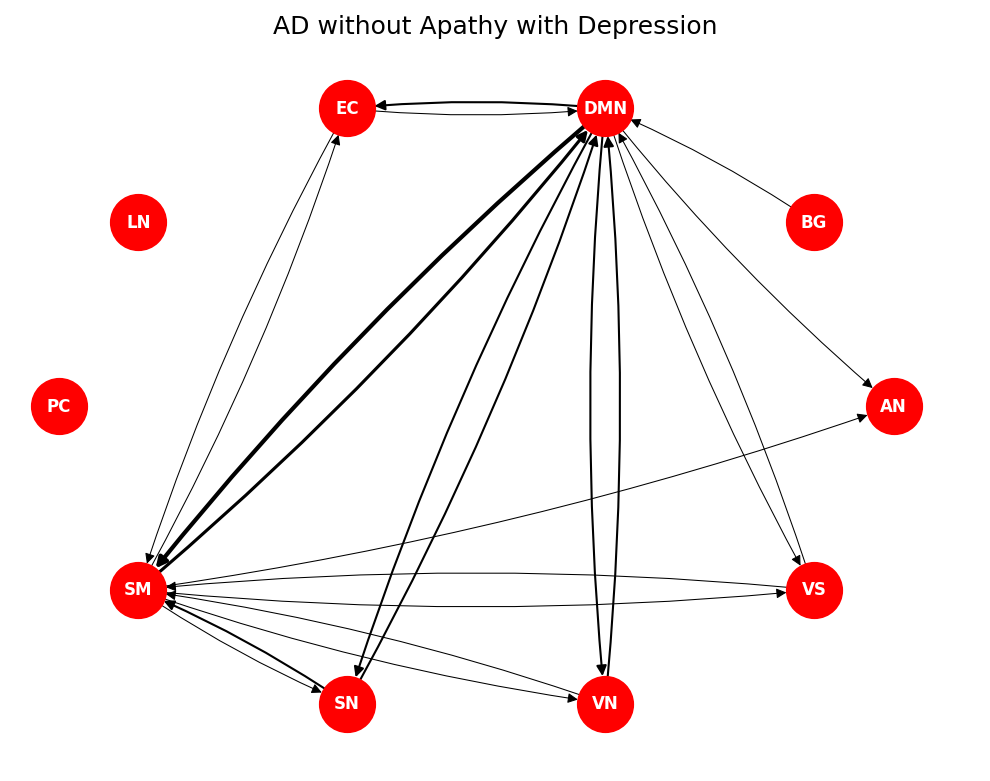

In [35]:
ad3_labels = np.array(['VDMN', 'PV', 'AN', 'DDMN', 'SM', 'PS', 'VDMN', 'SM', 'VS', 'SM', 'PC', 'VS', 'LEC', 'HV', 'BG', 'AS', 'LN', 'LEC', 'DDMN', 'SM', 'REC', 'PS', 'BG', 'DDMN', 'SM', 'DDMN', 'SM', 'DDMN', 'AS', 'HV', 'DDMN'])

df_ad3 = pd.DataFrame(ad3_result, index=ad3_labels, columns=ad3_labels)

matrix_ad3, weights_ad3 = map_to_graph(df_ad3, marginal_connections=False, node_color='red', graph_title='AD without Apathy with Depression')

### dDTF values matrix

Independent of dDTF scaling wrt maximum value

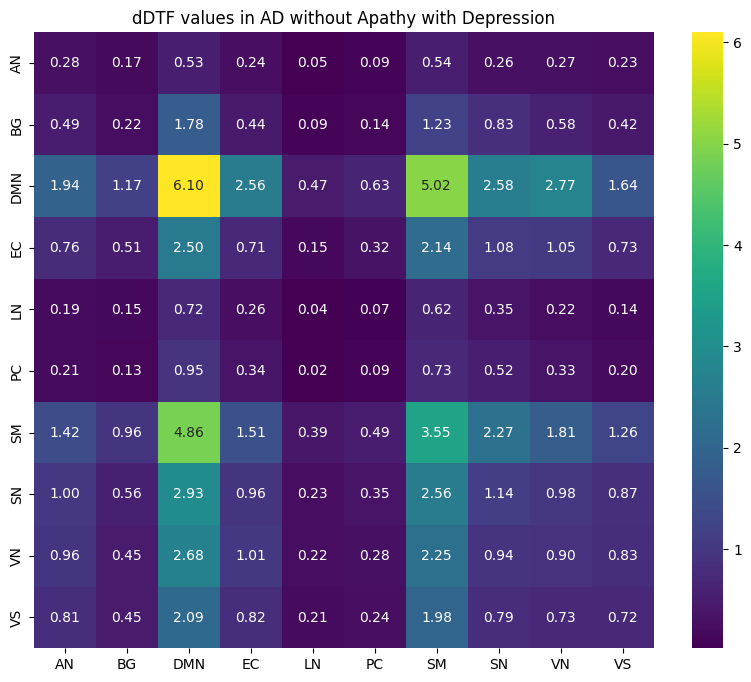

In [36]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix_ad3, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("dDTF values in AD without Apathy with Depression")
plt.show()

### Standardized dDTF matrix for AD3

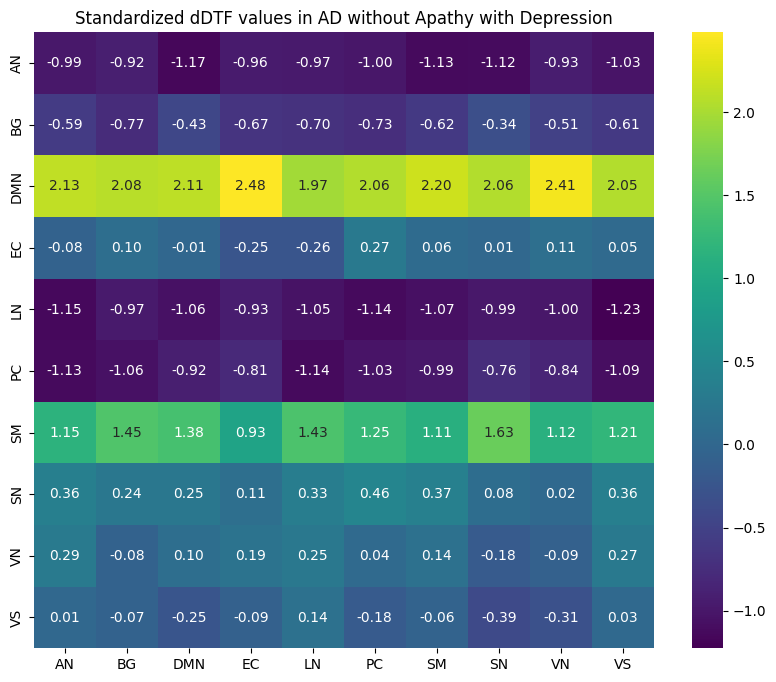

In [37]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(normalize_matrix(matrix_ad3), cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("Standardized dDTF values in AD without Apathy with Depression")
plt.show()

### In+Out degrees in AD3

In [38]:
ad3_in = np.sum(weights_ad3.values, axis=1)
ad3_out = np.sum(weights_ad3.values, axis=0)
ad3_in_out = ad3_in + ad3_out

# fd: flow-degrees, for in, out, in+out degrees
fd_ad3 = pd.DataFrame(np.vstack((ad3_in, ad3_out, ad3_in_out)), columns=weights_ad3.columns, index=['In-Degree', 'Out-Degree', 'In+Out'])
fd_ad3

,AN,BG,DMN,EC,LN,PC,SM,SN,VN,VS
In-Degree,0.0,0.25,3.0,0.50,0.0,0.0,2.00,1.00,0.75,0.5
Out-Degree,0.5,0.00,2.5,0.75,0.0,0.0,2.25,0.75,0.75,0.5
In+Out,0.5,0.25,5.5,1.25,0.0,0.0,4.25,1.75,1.50,1.0


### Hubs in AD3

In [39]:
mean_io_ad3 = np.mean(fd_ad3.values[2,:]) #io: in+out
sd_io_ad3 = np.std(fd_ad3.values[2,:])

for n in range(len(fd_ad3.values[2,:])):
    if fd_ad3.values[2,n] >= mean_io_ad3 + sd_io_ad3:
        print(fd_ad3.columns[n])

DMN
SM


### Mean and SD in+out in AD3

In [40]:
print(mean_io_ad3)
print(sd_io_ad3)

1.6
1.7578395831246947


### Larger In-degrees in AD3

In [41]:
mean_in_ad3 = np.mean(fd_ad3.values[0,:]) #cn: control, io: in+out
sd_in_ad3 = np.std(fd_ad3.values[0,:])

for n in range(len(fd_ad3.values[0,:])):
    if fd_ad3.values[0,n] >= mean_in_ad3 + sd_in_ad3:
        print(fd_ad3.columns[n])

DMN
SM


### Larger Out-degrees in AD3

In [42]:
mean_out_ad3 = np.mean(fd_ad3.values[1,:]) #cn: control, io: in+out
sd_out_ad3 = np.std(fd_ad3.values[1,:])

for n in range(len(fd_ad3.values[1,:])):
    if fd_ad3.values[1,n] >= mean_out_ad3 + sd_out_ad3:
        print(fd_ad3.columns[n])

DMN
SM


# AD without Apathy without Depression - AD4

Basal ganglia was manually labeled.

In [43]:
ad4_ics = nib.load("E:/Internship/Group-IC/AD4/ad4_mean_timecourses_ica_s_all_.nii").get_fdata()

surrogate_ad4 = mGrangerStats(ad4_ics)

surrogate_array_ad4 = surrogate_ad4.generate_surrogate(num_sets=2500)

ad4_result = surrogate_ad4.significance_testing(surrogate_array_ad4, 0.05)

### Suppressed connections

In [44]:
print(np.size(ad4_result) - np.count_nonzero(ad4_result))

3


## Without marginal connections

### Graph

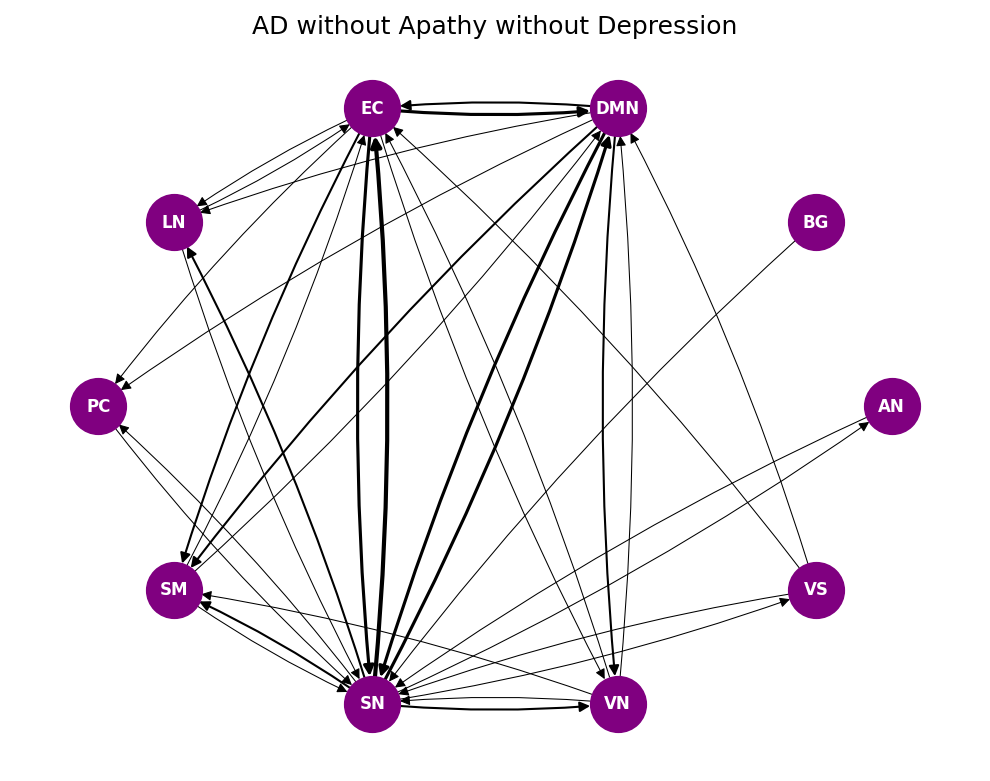

In [45]:
ad4_labels = np.array(['BG', 'AS', 'SM', 'LN', 'HV', 'PS', 'PC', 'AS', 'VDMN', 'SM', 
    'REC', 'REC', 'VS', 'AS', 'SM', 'VDMN', 'REC', 'LN', 'AN', 'DDMN', 'PS', 'REC', 'AN', 
    'DDMN', 'AS', 'VDMN', 'PC', 'HV', 'REC', 'PV', 'VS'])

df_ad4 = pd.DataFrame(ad4_result, index=ad4_labels, columns=ad4_labels)

matrix_ad4, weights_ad4 = map_to_graph(df_ad4, marginal_connections=False, node_color='purple', graph_title='AD without Apathy without Depression')

### dDTF values matrix

Independent of dDTF scaling wrt maximum value

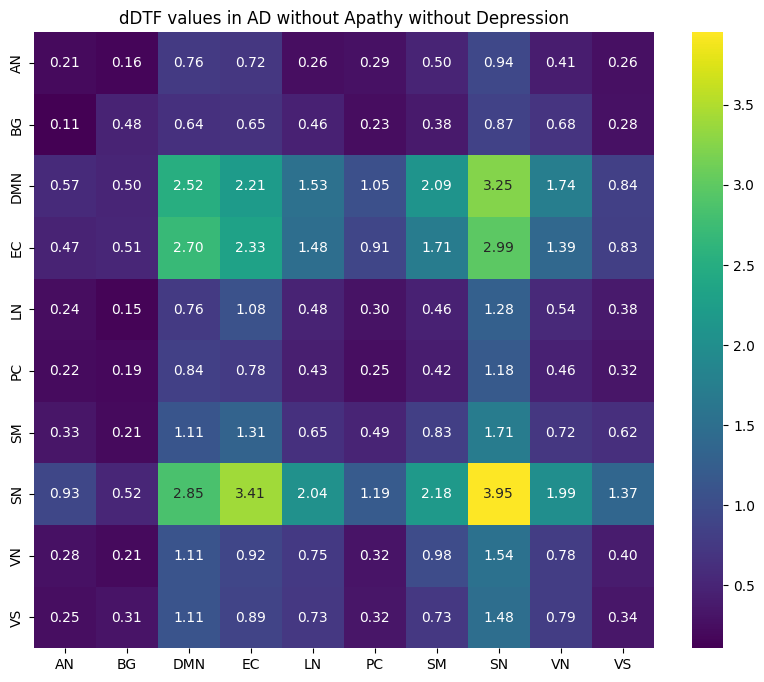

In [46]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix_ad4, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("dDTF values in AD without Apathy without Depression")
plt.show()

### Standardized dDTF matrix in AD4

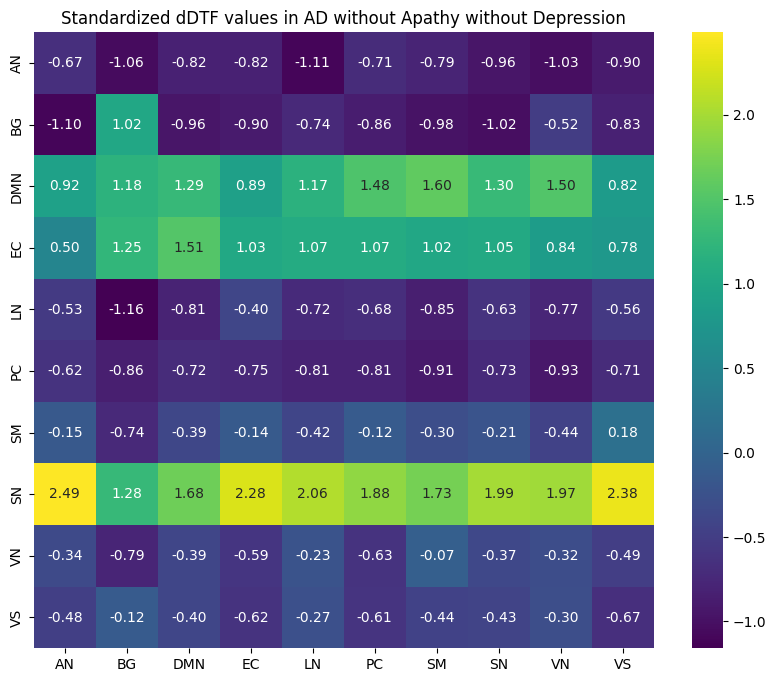

In [47]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(normalize_matrix(matrix_ad4), cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("Standardized dDTF values in AD without Apathy without Depression")
plt.show()

### In+Out degrees

In [48]:
ad4_in = np.sum(weights_ad4.values, axis=1)
ad4_out = np.sum(weights_ad4.values, axis=0)
ad4_in_out = ad4_in + ad4_out

# fd: flow-degrees, for in, out, in+out degrees
fd_ad4 = pd.DataFrame(np.vstack((ad4_in, ad4_out, ad4_in_out)), columns=weights_ad4.columns, index=['In-Degree', 'Out-Degree', 'In+Out'])
fd_ad4

,AN,BG,DMN,EC,LN,PC,SM,SN,VN,VS
In-Degree,0.25,0.25,2.75,2.75,0.5,0.25,0.75,4.00,1.00,0.75
Out-Degree,0.25,0.00,2.25,2.50,1.0,0.75,1.75,3.25,1.25,0.25
In+Out,0.50,0.25,5.00,5.25,1.5,1.00,2.50,7.25,2.25,1.00


### Hubs in AD4

In [49]:
mean_io_ad4 = np.mean(fd_ad4.values[2,:]) #io: in+out
sd_io_ad4 = np.std(fd_ad4.values[2,:])

for n in range(len(fd_ad4.values[2,:])):
    if fd_ad4.values[2,n] >= mean_io_ad4 + sd_io_ad4:
        print(fd_ad4.columns[n])

DMN
EC
SN


### Mean and SD In+Out in AD4

In [50]:
print(mean_io_ad4)
print(sd_io_ad4)

2.65
2.2533308678487494


### Larger In-degrees in AD4

In [51]:
mean_in_ad4 = np.mean(fd_ad4.values[0,:]) #cn: control, io: in+out
sd_in_ad4 = np.std(fd_ad4.values[0,:])

for n in range(len(fd_ad4.values[0,:])):
    if fd_ad4.values[0,n] >= mean_in_ad4 + sd_in_ad4:
        print(fd_ad4.columns[n])

DMN
EC
SN


### Larger Out-degrees in AD4

In [52]:
mean_out_ad4 = np.mean(fd_ad4.values[1,:]) #cn: control, io: in+out
sd_out_ad4 = np.std(fd_ad4.values[1,:])

for n in range(len(fd_ad4.values[1,:])):
    if fd_ad4.values[1,n] >= mean_out_ad4 + sd_out_ad4:
        print(fd_ad4.columns[n])

EC
SN
